In [1]:
import os, glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import Callback,EarlyStopping
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from sklearn.metrics import  classification_report

In [2]:
file_path = '../input/plantdisease/PlantVillage'

In [3]:
name_class = os.listdir(file_path)
name_class

['Pepper__bell___Bacterial_spot',
 'Potato___healthy',
 'Tomato_Leaf_Mold',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato_Bacterial_spot',
 'Tomato_Septoria_leaf_spot',
 'Tomato_healthy',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato_Early_blight',
 'Tomato__Target_Spot',
 'Pepper__bell___healthy',
 'Potato___Late_blight',
 'Tomato_Late_blight',
 'Potato___Early_blight',
 'Tomato__Tomato_mosaic_virus']

In [4]:
filepaths = list(glob.glob(file_path+'/**/*.*'))

In [5]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepath = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
data = pd.concat([filepath, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head(5)


,Filepath,Label
0,../input/plantdisease/PlantVillage/Tomato__Tar...,Tomato__Target_Spot
1,../input/plantdisease/PlantVillage/Tomato_heal...,Tomato_healthy
2,../input/plantdisease/PlantVillage/Pepper__bel...,Pepper__bell___Bacterial_spot
3,../input/plantdisease/PlantVillage/Tomato_Earl...,Tomato_Early_blight
4,../input/plantdisease/PlantVillage/Tomato_Spid...,Tomato_Spider_mites_Two_spotted_spider_mite


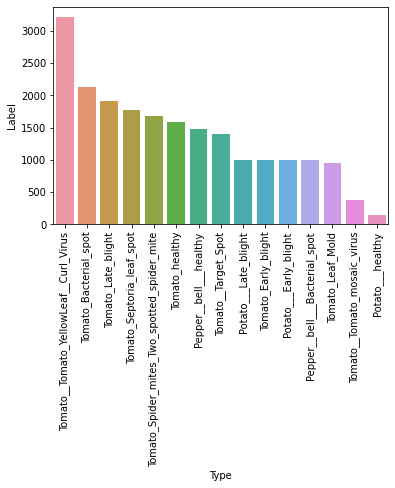

In [6]:
counts = data.Label.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Type')
plt.xticks(rotation=90);

In [7]:
train, test = train_test_split(data, test_size=0.25, random_state=42)

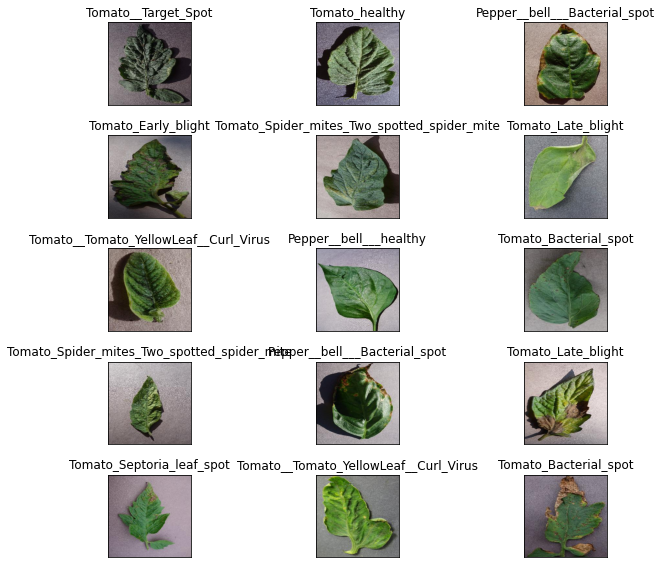

In [8]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10,8), subplot_kw={'xticks':[],'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.Filepath[i]))
    ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

In [9]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                  validation_split=0.2)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [10]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42
)
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 15478 validated image filenames belonging to 15 classes.
Found 15478 validated image filenames belonging to 15 classes.
Found 5160 validated image filenames belonging to 15 classes.


In [11]:
pretrained_model = ResNet50(
    input_shape=(100,100, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

94773248/94765736 [==============================] - 2s 0us/step


In [12]:
inputs = pretrained_model.input

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dense(128, activation='relu')(x)

outputs = Dense(15, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [13]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [14]:
# my_callbacks  = [EarlyStopping(monitor='val_accuracy',
#                               min_delta=0,
#                               patience=2,
#                               mode='auto')]

In [15]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=10,
)

Epoch 1/10
484/484 [==============================] - 129s 248ms/step - loss: 0.9284 - accuracy: 0.7046 - val_loss: 0.2632 - val_accuracy: 0.9135
Epoch 2/10
484/484 [==============================] - 69s 142ms/step - loss: 0.2530 - accuracy: 0.9152 - val_loss: 0.1804 - val_accuracy: 0.9369
Epoch 3/10
484/484 [==============================] - 69s 142ms/step - loss: 0.1754 - accuracy: 0.9395 - val_loss: 0.1155 - val_accuracy: 0.9625
Epoch 4/10
484/484 [==============================] - 69s 142ms/step - loss: 0.1308 - accuracy: 0.9539 - val_loss: 0.1082 - val_accuracy: 0.9618
Epoch 5/10
484/484 [==============================] - 68s 142ms/step - loss: 0.0986 - accuracy: 0.9655 - val_loss: 0.0686 - val_accuracy: 0.9771
Epoch 6/10
484/484 [==============================] - 70s 144ms/step - loss: 0.0969 - accuracy: 0.9652 - val_loss: 0.0886 - val_accuracy: 0.9686
Epoch 7/10
484/484 [==============================] - 71s 148ms/step - loss: 0.0729 - accuracy: 0.9743 - val_loss: 0.0720 - val_a

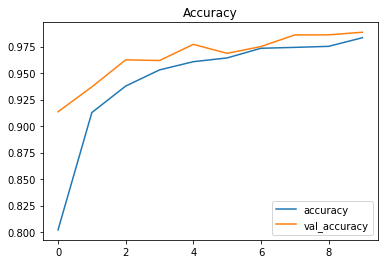

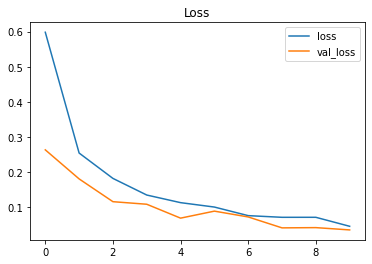

In [16]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [17]:
results = model.evaluate(test_gen, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.25543
Test Accuracy: 93.47%


In [18]:
pred = model.predict(test_gen)
pred = np.argmax(pred,axis=1)

labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [19]:
y_test = list(test.Label)
print(classification_report(y_test, pred))

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.92      0.97      0.94       230
                     Pepper__bell___healthy       0.99      0.98      0.99       351
                      Potato___Early_blight       0.94      0.99      0.96       241
                       Potato___Late_blight       0.96      0.91      0.93       261
                           Potato___healthy       0.97      0.94      0.96        35
                      Tomato_Bacterial_spot       0.92      0.99      0.95       518
                        Tomato_Early_blight       0.86      0.74      0.79       257
                         Tomato_Late_blight       0.90      0.93      0.91       495
                           Tomato_Leaf_Mold       0.95      0.85      0.90       235
                  Tomato_Septoria_leaf_spot       0.90      0.93      0.91       452
Tomato_Spider_mites_Two_spotted_spider_mite       0.94      0.91

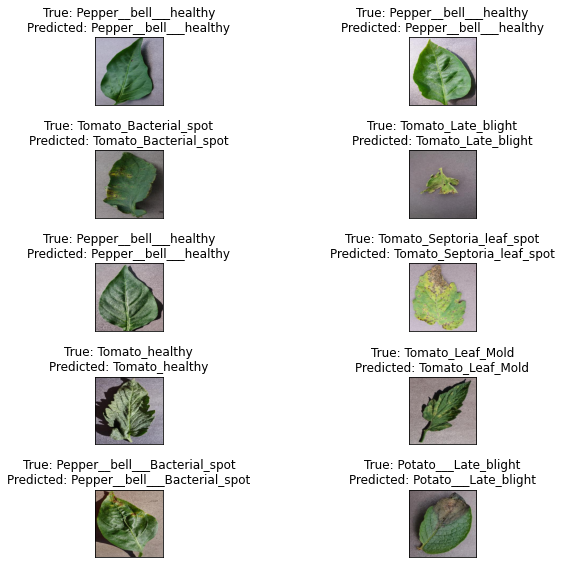

In [20]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test.Filepath.iloc[i]))
    ax.set_title(f"True: {test.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

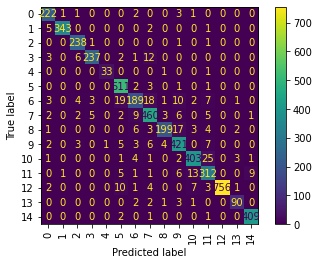

In [34]:
import sklearn.metrics as metrics
confusion_matrix = metrics.confusion_matrix(y_true=y_test, y_pred=pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,display_labels=labels)
disp.plot(xticks_rotation='vertical')
